In [1]:
import yfinance as yf
import pandas as pd
import datetime
import pytz
import math
import time
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
#Imported from Yahoo! finance, the stock value of TSM. This is what we will try to predict

data = yf.download("TSM", start="2000-09-01", end="2023-07-30")

[*********************100%***********************]  1 of 1 completed


In [3]:
#Most basic metric: daily return

data['return'] = data['Adj Close']/data['Adj Close'].shift() - 1

In [4]:
#Some other metrics that will be inputted into the neural network as data

data['mean_last10days'] = data['return'].rolling(10).mean().shift(1)
data['mean_last20days'] = data['return'].rolling(20).mean().shift(1)
data['std_last10days'] = data['return'].rolling(10).std().shift(1)
data['mean_last20days_weighted'] = data['mean_last20days'] * data['Volume'].rolling(20).sum().shift(1)
data['mean10overstd'] = data['mean_last10days']/data['std_last10days']
data['mean10overreturn'] = data['mean_last10days']/data['return'].shift(1)
data['returnovervolume'] = data['return'].shift(1)/data['Volume'].shift(1)
data['return1_corr_return2'] = data['return'].shift(1).rolling(20).corr(data['return'].shift(2))
data['mean_last20days_corrweighted'] = data['mean_last20days'] * data['return1_corr_return2']

In [5]:
#In addition to metrics based off of TSM stock price, we will also introduce five other indicators

spy = yf.download("SPY", start="2000-09-01", end="2023-07-30")
qqq = yf.download("QQQ", start="2000-09-01", end="2023-07-30")
gold = yf.download("GC=F", start="2000-09-01", end="2023-07-30")
oil = yf.download("CL=F", start="2000-09-01", end="2023-07-30")
intel = yf.download("INTC", start="2000-09-01", end="2023-07-30")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Making original metric
#This metric counts the consecutive number of days that daily return has been positive or negative
#Note that for consecutive days with negative return, the metric stores 0, -1, -2, ...

increasing = [0]
increasing.append(0)
cur = 0

data['issame'] = data['return']* data['return'].shift(1)

for index, row in data.iterrows():
    if(index > dt.datetime(2000,9,5).date()):
        if(row['issame']>0 and row['return'] > 0): 
            increasing.append(cur+1)
            cur+=1
        elif(row['issame']>0 and row['return'] < 0): 
            increasing.append(cur-1)
            cur-=1
        else:
            increasing.append(0)
            cur = 0

#len(increasing)

/var/folders/3f/d2nxdp4945gg5vrpppgw_9mh0000gn/T/ipykernel_1228/3667262523.py:12: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if(index > dt.datetime(2000,9,5).date()):


In [7]:
#Making original metric
#Similar idea as above but for returns
#Stores how much stock price has increased since last decrease OR how much it has decreased since last increase

streak = [0]
streak.append(data.iloc[1]['return'])
cur = data.iloc[1]['return']

for index, row in data.iterrows():
    if(index > dt.datetime(2000,9,5).date()):
        if(row['issame']>0 and row['return'] > 0):
            cur = (cur+1) * (row['return']+1)-1
            streak.append(cur)
        elif(row['issame']>0 and row['return'] < 0): 
            cur = - ((cur+1) * (row['return']+1)-1)
            streak.append(cur)
        else:
            cur = row['return']
            streak.append(cur)

/var/folders/3f/d2nxdp4945gg5vrpppgw_9mh0000gn/T/ipykernel_1228/3726740269.py:10: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if(index > dt.datetime(2000,9,5).date()):


In [8]:
#Add new metrics to data
data['increasing'] = increasing
data['increasing'] = data['increasing'].shift(1)
data['streak'] = streak
data['streak'] = data['streak'].shift(1)

#Weightted return is a metric that highlights return on days where returns have been consistently good or bad
data['weighted return'] = data['return'].shift(1) * data['increasing']

In [9]:
#Data for model

for_model = data

In [10]:
#The following cells make our data useable for our neural network

In [11]:
for_model['spy_Open'] = spy['Open']
for_model['spy_High'] = spy['High']
for_model['spy_Low'] = spy['Low']
for_model['spy_Close'] = spy['Close']
for_model['spy_Adj Close'] = spy['Adj Close']
for_model['spy_Volume'] = spy['Volume']
for_model['spy_return'] = data['spy_Adj Close']/data['spy_Adj Close'].shift() - 1

In [12]:
for_model['qqq_Open'] = qqq['Open']
for_model['qqq_High'] = qqq['High']
for_model['qqq_Low'] = qqq['Low']
for_model['qqq_Close'] = qqq['Close']
for_model['qqq_Adj Close'] = qqq['Adj Close']
for_model['qqq_Volume'] = qqq['Volume']
for_model['qqq_return'] = data['qqq_Adj Close']/data['qqq_Adj Close'].shift() - 1

In [13]:
for_model['gold_Open'] = gold['Open']
for_model['gold_High'] = gold['High']
for_model['gold_Low'] = gold['Low']
for_model['gold_Close'] = gold['Close']
for_model['gold_Adj Close'] = gold['Adj Close']
for_model['gold_Volume'] = gold['Volume']
for_model['gold_return'] = data['gold_Adj Close']/data['gold_Adj Close'].shift() - 1

In [14]:
for_model['oil_Open'] = oil['Open']
for_model['oil_High'] = oil['High']
for_model['oil_Low'] = oil['Low']
for_model['oil_Close'] = oil['Close']
for_model['oil_Adj Close'] = oil['Adj Close']
for_model['oil_Volume'] = oil['Volume']
for_model['oil_return'] = data['oil_Adj Close']/data['oil_Adj Close'].shift() - 1

In [15]:
for_model['intel_Open'] = intel['Open']
for_model['intel_High'] = intel['High']
for_model['intel_Low'] = intel['Low']
for_model['intel_Close'] = intel['Close']
for_model['intel_Adj Close'] = intel['Adj Close']
for_model['intel_Volume'] = intel['Volume']
for_model['intel_return'] = data['intel_Adj Close']/data['intel_Adj Close'].shift() - 1

In [20]:
for_model = for_model.reset_index().dropna()

In [24]:
#for_model

In [25]:
for_model['D'] = pd.to_datetime(for_model['Date']).dt.date

In [26]:
#Splitting data into training and testing

training = for_model[for_model['D'] < dt.datetime(2021,10,1).date()]
testing = for_model[for_model['D'] > dt.datetime(2021,10,1).date()]

In [27]:
#Split into input and output

Y_data = for_model['return']
X_data = for_model[['mean_last10days', 'mean_last20days', 'std_last10days', 'mean_last20days_weighted', 'mean10overstd', 'returnovervolume', 'return1_corr_return2', 'mean_last20days_corrweighted', 'issame', 'increasing', 'streak', 'weighted return', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'spy_Open', 'spy_Close', 'spy_High', 'spy_Low', 'spy_Adj Close', 'spy_Volume', 'spy_return', 'qqq_Open', 'qqq_Close', 'qqq_High', 'qqq_Low', 'qqq_Adj Close', 'qqq_Volume', 'qqq_return', 'gold_Open', 'gold_Close', 'gold_High', 'gold_Low', 'gold_Adj Close', 'gold_Volume', 'gold_return', 'oil_Open', 'oil_Close', 'oil_High', 'oil_Low', 'oil_Adj Close', 'oil_Volume', 'oil_return', 'intel_Open', 'intel_Close', 'intel_High', 'intel_Low', 'intel_Adj Close', 'intel_Volume', 'intel_return']]
Y_data = Y_data.to_numpy()
X_data = X_data.to_numpy().T

In [28]:
#find maximums for each data point
#For normalizing data later on which icnreases performance

maxes = np.max(X_data, axis=1, keepdims=True)
#maxes

In [30]:
#testing

In [31]:
#Split training and testing data into input and output like above

Y_dev = training['return']
X_dev = training[['mean_last10days', 'mean_last20days', 'std_last10days', 'mean_last20days_weighted', 'mean10overstd', 'returnovervolume', 'return1_corr_return2', 'mean_last20days_corrweighted', 'issame', 'increasing', 'streak', 'weighted return', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'spy_Open', 'spy_Close', 'spy_High', 'spy_Low', 'spy_Adj Close', 'spy_Volume', 'spy_return', 'qqq_Open', 'qqq_Close', 'qqq_High', 'qqq_Low', 'qqq_Adj Close', 'qqq_Volume', 'qqq_return', 'gold_Open', 'gold_Close', 'gold_High', 'gold_Low', 'gold_Adj Close', 'gold_Volume', 'gold_return', 'oil_Open', 'oil_Close', 'oil_High', 'oil_Low', 'oil_Adj Close', 'oil_Volume', 'oil_return', 'intel_Open', 'intel_Close', 'intel_High', 'intel_Low', 'intel_Adj Close', 'intel_Volume', 'intel_return']]
Y_train = testing['return']
X_train = testing[['mean_last10days', 'mean_last20days', 'std_last10days', 'mean_last20days_weighted', 'mean10overstd', 'returnovervolume', 'return1_corr_return2', 'mean_last20days_corrweighted', 'issame', 'increasing', 'streak', 'weighted return', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'spy_Open', 'spy_Close', 'spy_High', 'spy_Low', 'spy_Adj Close', 'spy_Volume', 'spy_return', 'qqq_Open', 'qqq_Close', 'qqq_High', 'qqq_Low', 'qqq_Adj Close', 'qqq_Volume', 'qqq_return', 'gold_Open', 'gold_Close', 'gold_High', 'gold_Low', 'gold_Adj Close', 'gold_Volume', 'gold_return', 'oil_Open', 'oil_Close', 'oil_High', 'oil_Low', 'oil_Adj Close', 'oil_Volume', 'oil_return', 'intel_Open', 'intel_Close', 'intel_High', 'intel_Low', 'intel_Adj Close', 'intel_Volume', 'intel_return']]


In [32]:
#Transpose (necessary for matrix multiplication for NN)

Y_dev = Y_dev.to_numpy()
X_dev = X_dev.to_numpy().T
Y_train = Y_train.to_numpy()
X_train = X_train.to_numpy().T

In [33]:
#Normalize data

X_dev = X_dev / maxes
X_train = X_train / maxes

In [35]:
#X_train

In [36]:
m, n = training.shape
m

5242

In [37]:
#This code cell is a very simple implementation of a CNN
#Somewhat funnily, there are no pooling layers

def init_params(layers, layer_sizes):
    weights = []
    biases = []
    for i in range(layers - 1):
        weights.append(np.random.rand(layer_sizes[i+1], layer_sizes[i]) * 2 - 1)
        biases.append(np.random.rand(layer_sizes[i+1], 1) * 2 - 1)
    return weights, biases

def ReLU(Z):
    return np.minimum(np.maximum(Z, 0), 1)

def softmax(Z):
    A = np.exp(Z - 100) / np.sum(np.exp(Z - 100), axis=0)
    return A

#Splits up outputs into 22 possibilities
#Buckets of return: 20 buckets splitting up -10% to 10% into 20 intervals, 2 buckets for above 10% and below -10%
def toIndex(y):
    ind = 0
    if(y < 0.1 and -0.1 <= y):
        ind = int(np.floor((y+0.1)*100)+1)
    elif(y<0.1):
        ind = 0
    else:
        ind = 21
    return ind

#Forward prop
#Uses ReLU for all layers but last layer as activation function. Softmax for last
def forward_prop(layers, weights, biases, X):
    Z = []
    A = []
    Z.append(weights[0].dot(X) + biases[0])
    A.append(ReLU(Z[0]))
    for i in range(1, layers - 2):
        Z.append(weights[i].dot(A[i-1]) + biases[i])
        A.append(ReLU(Z[i]))
    Z.append(weights[layers - 2].dot(A[layers - 3]) + biases[layers - 2])
    A.append(softmax(Z[layers - 2]))
    return Z, A

def ReLU_deriv(Z):
    return (Z >= 0) & (Z <= 1)

def one_hot(Y):
    one_hot_Y = np.zeros((22, m))
    for i in range(0, m):
        one_hot_Y[toIndex(Y[i])][i] = 1
    return one_hot_Y

#Backwards prop to find out how to change parameters
def backward_prop(Z, A, weights, biases, X, Y, layers):
    dWeights = []
    dBiases = []
    one_hot_Y = one_hot(Y)
    dZ = A[layers - 2] - one_hot_Y
    dWeights.append(1 / m * dZ.dot(A[layers - 3].T))
    dBiases.append(1 / m * np.sum(dZ))
    for i in reversed(range(1, layers - 2)):
        dZ = weights[i + 1].T.dot(dZ) * ReLU_deriv(Z[i])
        dWeights.append(1 / m * dZ.dot(A[i - 1].T))
        dBiases.append(1 / m * np.sum(dZ))
    dZ = weights[1].T.dot(dZ) * ReLU_deriv(Z[0])
    dWeights.append(1 / m * dZ.dot(X.T))
    dBiases.append(1 / m * np.sum(dZ))
    return dWeights, dBiases

#Change parameters
def update_params(weights, biases, dWeights, dBiases, alpha, layers):
    for i in range(layers - 1):
        weights[i] = weights[i] - alpha * dWeights[layers - 2 - i]
        biases[i] = biases[i] - alpha * dBiases[layers - 2 - i]
    return weights, biases

In [38]:

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    ksum = 0
    for i in range(0, m):
        if(predictions[i] == toIndex(Y[i])):
            ksum = ksum + 1
    return ksum / m

#this function repeatedly runs forward and backward propagation to train neural network 
def gradient_descent(X, Y, alpha, iterations, limit, layers, layer_sizes):
    weights, biases = init_params(layers, layer_sizes)
    start = time.time()
    while(time.time() - start < limit):
        Z, A = forward_prop(layers, weights, biases, X)
        dWeights, dBiases = backward_prop(Z, A, weights, biases, X, Y, layers)
        weights, biases = update_params(weights, biases, dWeights, dBiases, alpha, layers)
    print("Iteration: ", iterations)
    predictions = get_predictions(A[layers - 2])
    print(get_accuracy(predictions, Y))
    print(easy_get_accuracy(predictions, Y))
    return weights, biases

#The above two cells conclude the code needed to initialize and train a neural network
#With a given number of layers and layer sizes

In [39]:
#This next cell contains some functions to calculate accuracy on training data as will as different ways of
#defining accuracy
#easy_get_accuracy and easy_get_accuracy_train calculate accuracy and testing and training data, respectively
#if an accurate prediction of positive or negative return is considered correct
#Recall that returns have been split into 22 buckets, normal accuracy counts how often NN gets bucket right

def make_predictions(layers, weights, biases, X):
    Z, A = forward_prop(layers, weights, biases, X)
    predictions = get_predictions(A[layers - 2])
    return predictions

def easy_get_accuracy(predictions, Y):
    ksum = 0
    for i in range(0, m):
        if((predictions[i] > 10 and toIndex(Y[i]) > 10) or (predictions[i] < 11 and toIndex(Y[i]) < 11)):
            ksum = ksum + 1
    return ksum / m

def easy_get_accuracy_train(predictions, Y):
    ksum = 0
    for i in range(0, 457):
        if((predictions[i] > 10 and toIndex(Y[i]) > 10) or (predictions[i] < 11 and toIndex(Y[i]) < 11)):
            ksum = ksum + 1
    return ksum / 457

def get_accuracy_train(predictions, Y):
    ksum = 0
    for i in range(0, 457):
        if(predictions[i] == toIndex(Y[i])):
            ksum = ksum + 1
    return ksum / 457

In [50]:
#Contains three hyperparameter-tuning schemes

#Random search defines random layers and layer_sizes
#There are some bounds on how big a layer can be and how many layers there can be
#t is how long to search for
def random_search(t):
    start = time.time()
    iteration = 1
    maxAccuracy = 0
    maxEasyAccuracy = 0
    while(time.time() - start < t):
        #Change max layer count:
        layers = int(np.floor(np.random.rand() * 7) + 3)
        #Change max layer size:
        layer_sizes = np.floor(np.random.rand(layers) * 100) + 1
        layer_sizes = layer_sizes.astype(int)
        layer_sizes[0] = 53
        layer_sizes[layers - 1] = 22
        weights, biases = gradient_descent(X_dev, Y_dev, 0.1, iteration, 60, layers, layer_sizes)
        Accuracy, EasyAccuracy = evaluate(layers, weights, biases)
        print(Accuracy, " ", EasyAccuracy)
        maxAccuracy = max(maxAccuracy, Accuracy)
        maxEasyAccuracy = max(maxEasyAccuracy, EasyAccuracy)
        iteration = iteration + 1
    print(maxAccuracy)
    print(maxEasyAccuracy)
    
#Grid search initializes and train NNs at predetermined intervals
def grid_search():
    start = time.time()
    iteration = 1
    maxAccuracy = 0
    maxEasyAccuracy = 0
    
    #change to range(2, 2^k) for maximum of k layers
    for i in range(2, 256):
        layers = int(math.log(i, 2)) + 2
        layer_sizes = np.zeros(layers)
        for j in range(0, layers - 2):
            
            #Checks for layer sizes 25 and 75 by using bit values of i
            #Can be changed
            if(int(i / (2**j)) % 2):
                layer_sizes[j+1] = 75
            else:
                layer_sizes[j+1] = 25
        layer_sizes[0] = 53
        layer_sizes[layers - 1] = 22
        layer_sizes = layer_sizes.astype(int)
        weights, biases = gradient_descent(X_dev, Y_dev, 0.1, iteration, 60, layers, layer_sizes)
        Accuracy, EasyAccuracy = evaluate(layers, weights, biases)
        print(Accuracy, " ", EasyAccuracy)
        maxAccuracy = max(maxAccuracy, Accuracy)
        maxEasyAccuracy = max(maxEasyAccuracy, EasyAccuracy)
        iteration = iteration + 1
    print(maxAccuracy)
    print(maxEasyAccuracy)

    
#Proper bayesian_optimization looks at some data points and assumes somes relationship between current and next
#data points
#Used a rectangular distribution to linearize relationship to simplify implementation
def bayesian_optimization(t):
    start = time.time()
    iteration = 1
    maxAccuracy = 0
    maxEasyAccuracy = 0
    layers = 3
    layer_sizes = [60, 60, 60, 60, 60, 60, 60]
    while(time.time() - start < t):
        for i in range(0, layers - 2):
            for j in range(0, 3):
                tls = layer_sizes[0: layers - 2]
                tls[i] = int(np.random.rand() * 100 + 1)
                weights, biases = gradient_descent(X_dev, Y_dev, 0.1, iteration, 60, layers, [53] + tls + [22])
                Accuracy, EasyAccuracy = evaluate(layers, weights, biases)
                if(Accuracy > maxAccuracy):
                    layer_sizes[i] = tls[i]
                print(Accuracy, " ", EasyAccuracy)
                maxAccuracy = max(maxAccuracy, Accuracy)
                maxEasyAccuracy = max(maxEasyAccuracy, EasyAccuracy)
                iteration = iteration + 1
        for i in range(3, 10):
            weights, biases = gradient_descent(X_dev, Y_dev, 0.1, iteration, 60, layers, [53] + layer_sizes[0: layers - 2] + [22])
            Accuracy, EasyAccuracy = evaluate(layers, weights, biases)
            if(Accuracy > maxAccuracy):
                layers = i
            print(Accuracy, " ", EasyAccuracy)
            maxAccuracy = max(maxAccuracy, Accuracy)
            maxEasyAccuracy = max(maxEasyAccuracy, EasyAccuracy)
            iteration = iteration + 1
    
            
            
def evaluate(layers, weights, biases):
    predictions = make_predictions(layers, weights, biases, X_train)
    Accuracy = get_accuracy_train(predictions, Y_train)
    EasyAccuracy = easy_get_accuracy_train(predictions, Y_train)
    return Accuracy, EasyAccuracy

In [51]:
#Testing

bayesian_optimization(60)
grid_search()
random_search()

KeyboardInterrupt: 

In [62]:
def gradient_descent2(X, Y, alpha, limit, layers, layer_sizes):
    it = 0
    AG = np.zeros(shape=(2000))
    EAG = np.zeros(shape=(2000))
    weights, biases = init_params(layers, layer_sizes)
    start = time.time()
    while(time.time() - start < limit):
        Z, A = forward_prop(layers, weights, biases, X)
        dWeights, dBiases = backward_prop(Z, A, weights, biases, X, Y, layers)
        weights, biases = update_params(weights, biases, dWeights, dBiases, alpha, layers)
        predictions = get_predictions(A[layers - 2])
        AG[it] = get_accuracy(predictions, Y)
        EAG[it] = easy_get_accuracy(predictions, Y)
        it = it + 1
    return AG, EAG
        
AG, EAG = gradient_descent2(X_dev, Y_dev, 0.11, 60, 4, [53, 60, 60, 22])

In [63]:
AG

array([0.05665776, 0.12056467, 0.13353682, ..., 0.        , 0.        ,
       0.        ])

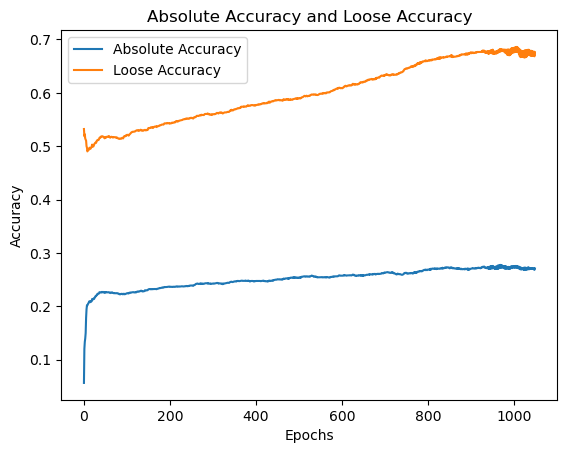

In [78]:
plt.plot(AG[0: 1050], label = 'Absolute Accuracy')
plt.plot(EAG[0: 1050], label = 'Loose Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Absolute Accuracy and Loose Accuracy')
plt.legend(loc="upper left")

plt.show()